In [30]:
import mthree

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit.visualization import plot_circuit_layout
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

import numpy as np
from matplotlib import pyplot as plt

In [74]:
def split_quasi_dist(qubit_subgroups, quasi_dist):
    """
    Sums the shots for subgroups of qubits from the total results.

    Parameters:
    - qubit_subgroups (list of lists): Each sublist contains the indices of qubits in the subgroup.
    - results (dict): The total results dictionary, with bitstrings as keys and shot counts as values.

    Returns:
    - List[dict]: A list of dictionaries, each representing the results for a qubit subgroup.
    """
    # Initialize a list of dictionaries to hold the results for each subgroup
    subgroup_quasi_dist = [{} for _ in qubit_subgroups]

    # Iterate over each result in the original results dictionary
    for bitstring, count in quasi_dist.items():
        # For each subgroup, extract the relevant bits and add the count
        for i, subgroup in enumerate(qubit_subgroups):
            # Extract the bits relevant to the current subgroup
            subgroup_bitstring = ''.join(bitstring[index] for index in subgroup)
            # Add the count to the corresponding bitstring in the subgroup's results
            if subgroup_bitstring in subgroup_quasi_dist[i]:
                subgroup_quasi_dist[i][subgroup_bitstring] += count
            else:
                subgroup_quasi_dist[i][subgroup_bitstring] = count

    return subgroup_quasi_dist

import mthree
def mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend):

    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(qubit_subgroup)
    
    quasis = mit.apply_correction(quasi_dist, qubit_subgroup, return_mitigation_overhead=True)
    return quasis


from qiskit.result import QuasiDistribution
def quasidist_bits_to_array(quasi_dist, N_qubits):
    '''
    Convert the quasidistribution disctionary to a probabilies vector, 
    sorting and filling the missing entries
    '''
    quasi_dist = QuasiDistribution(quasi_dist)
    
    probs_array = np.zeros(2**N_qubits)
    inds = np.array(list(quasi_dist.keys()))
    vals = np.array(list(quasi_dist.values()))
    probs_array[inds] = vals
    
    return probs_array

def avarage_distributions(distributions):
    """
    Sums multiple quantum state probability distributions into a single distribution.
    
    Parameters:
    - distributions (list of dict): A list where each element is a dictionary representing
                                    a quantum state probability distribution.
    
    Returns:
    - dict: A single dictionary representing the summed probability distribution.
    """
    # Initialize an empty dictionary for the summed distribution
    summed_distribution = {}

    n = len(distributions)
    
    # Iterate over each distribution in the list
    for distribution in distributions:
        # Iterate over each quantum state and its probability in the current distribution
        for state, probability in distribution.items():
            # Normalise
            probability/=n
            # If the quantum state is already in the summed distribution, add the probability
            if state in summed_distribution:
                summed_distribution[state] += probability
            # Otherwise, add the state and probability to the summed distribution
            else:
                summed_distribution[state] = probability
                
    return summed_distribution

In [3]:
service = QiskitRuntimeService(channel="ibm_cloud"
                              )
backend_brisbane = service.backend("ibm_brisbane")
backend_sim_brisbane = AerSimulator.from_backend(backend_brisbane)

snake_qubit_inds = np.concatenate(
    [np.arange(13,-1,-1), [14], np.arange(18,33), [36], 
    np.arange(51,37-1,-1), [52], np.arange(56,71), [74], 
    np.arange(89,75-1,-1), [90], np.arange(94,109), [112], np.arange(126,113-1,-1)]
)

backend_sim_air      = qiskit_aer.Aer.get_backend('aer_simulator')

sampler_sim_brisbane = BackendSampler(backend_sim_brisbane)
sampler_sim_air = BackendSampler(backend_sim_air)

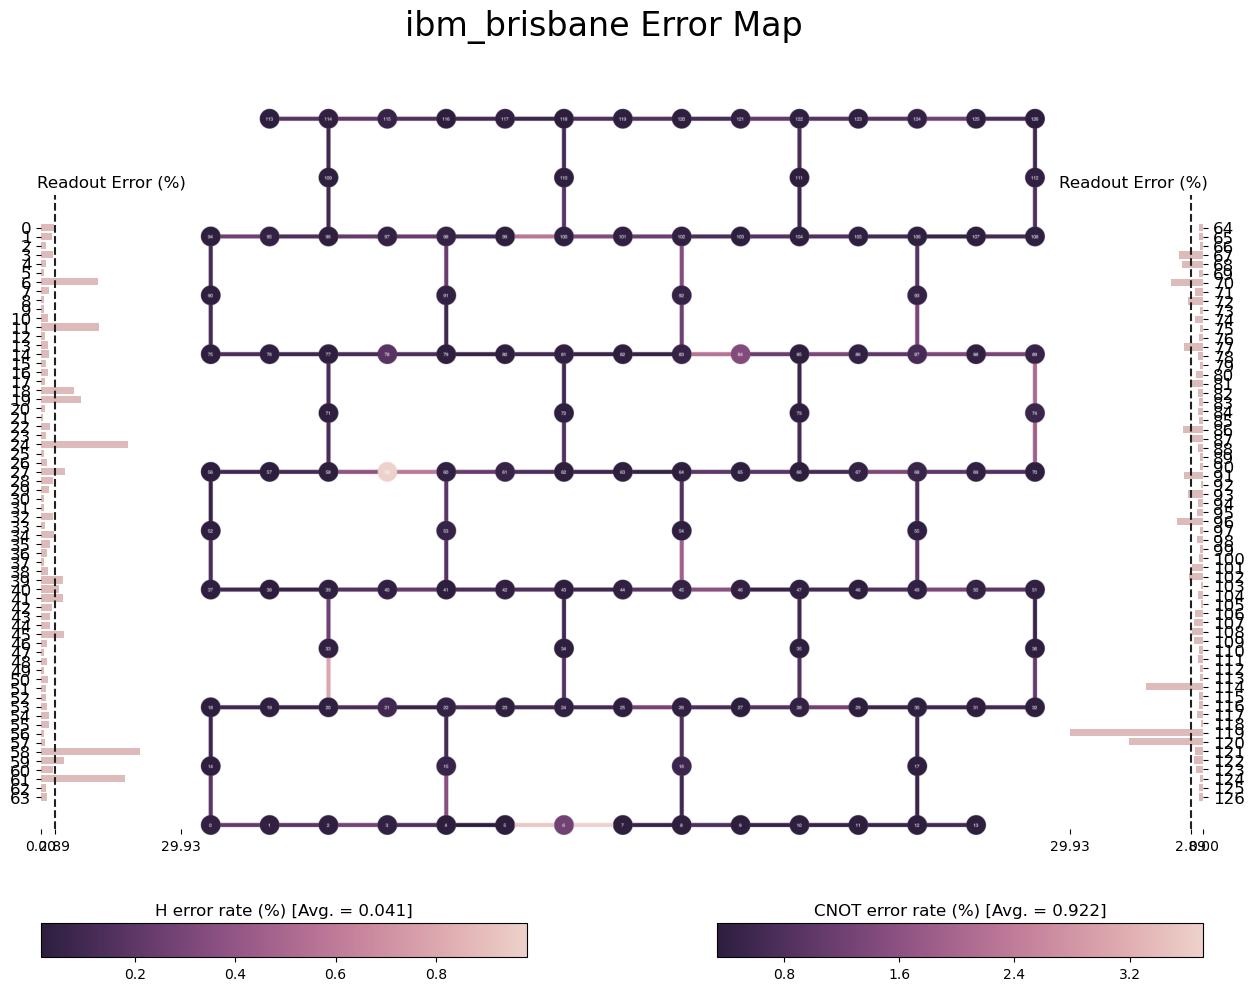

In [4]:
from qiskit.visualization import plot_error_map
plot_error_map(backend_brisbane)

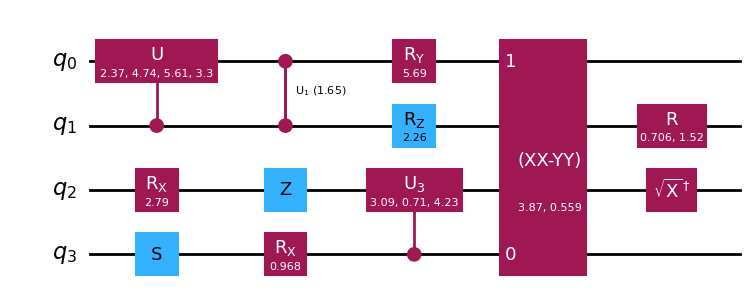

In [112]:
from qiskit.circuit.random import random_circuit

N_qubits = 4
N_layers = 4
circuit = random_circuit(N_qubits, N_layers)
circuit.draw(output='mpl')

In [143]:
# Maximum number of circuit. Use on real QPU
N_circuits = len(snake_qubit_inds) // N_qubits
# Number of circuits to be able to simulate classically. Use for test.
N_circuits = 3

N_qubits_tot = N_circuits*N_qubits
snake_qubit_inds_active = snake_qubit_inds[:N_qubits_tot]
# Subgroups to encode the circuits
qubit_subgroups = snake_qubit_inds_active.reshape(-1,N_qubits)

In [144]:
# Combine to one large circuit
N_c_bits = max(snake_qubit_inds_active)+1
full_circ = QuantumCircuit(N_qubits_tot, N_c_bits)
for i in range(N_circuits):
    full_circ.append(circuit, range(i*N_qubits,(i+1)*N_qubits))

# Fit into QPU
t_qc = transpile(
  full_circ,
  backend_sim_brisbane,
  initial_layout=snake_qubit_inds[:N_qubits_tot],
  optimization_level=3,
)

# Measure to cbits at specific locations to be able to interprete the result
for qubit_subgroup in qubit_subgroups:
    t_qc.measure(qubit_subgroup, (N_c_bits - qubit_subgroup - 1)[::-1])

/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viach

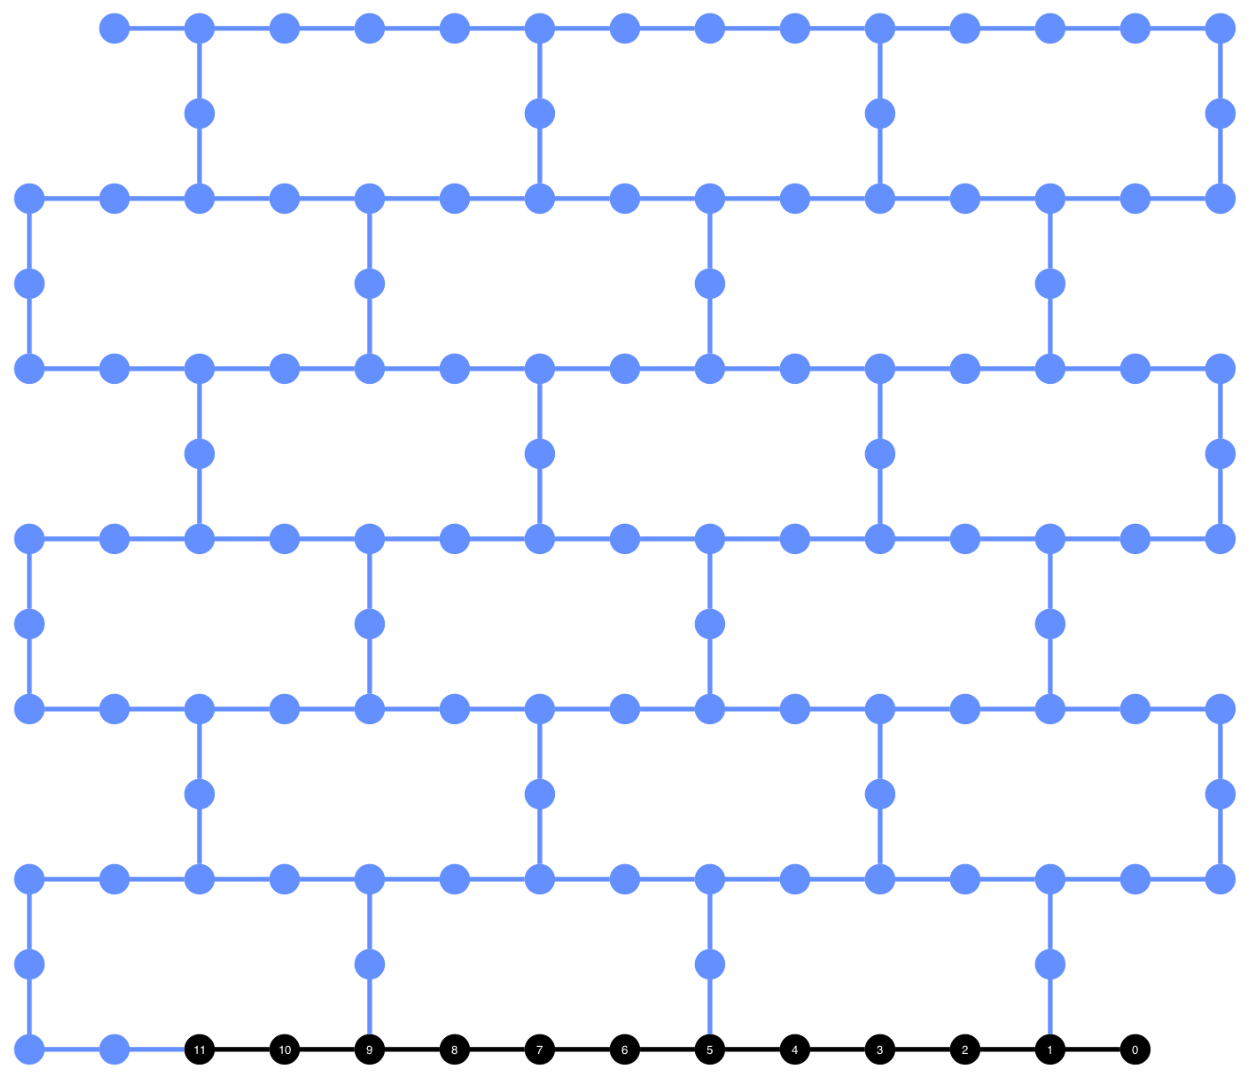

In [145]:
plot_circuit_layout(t_qc, backend_sim_brisbane)

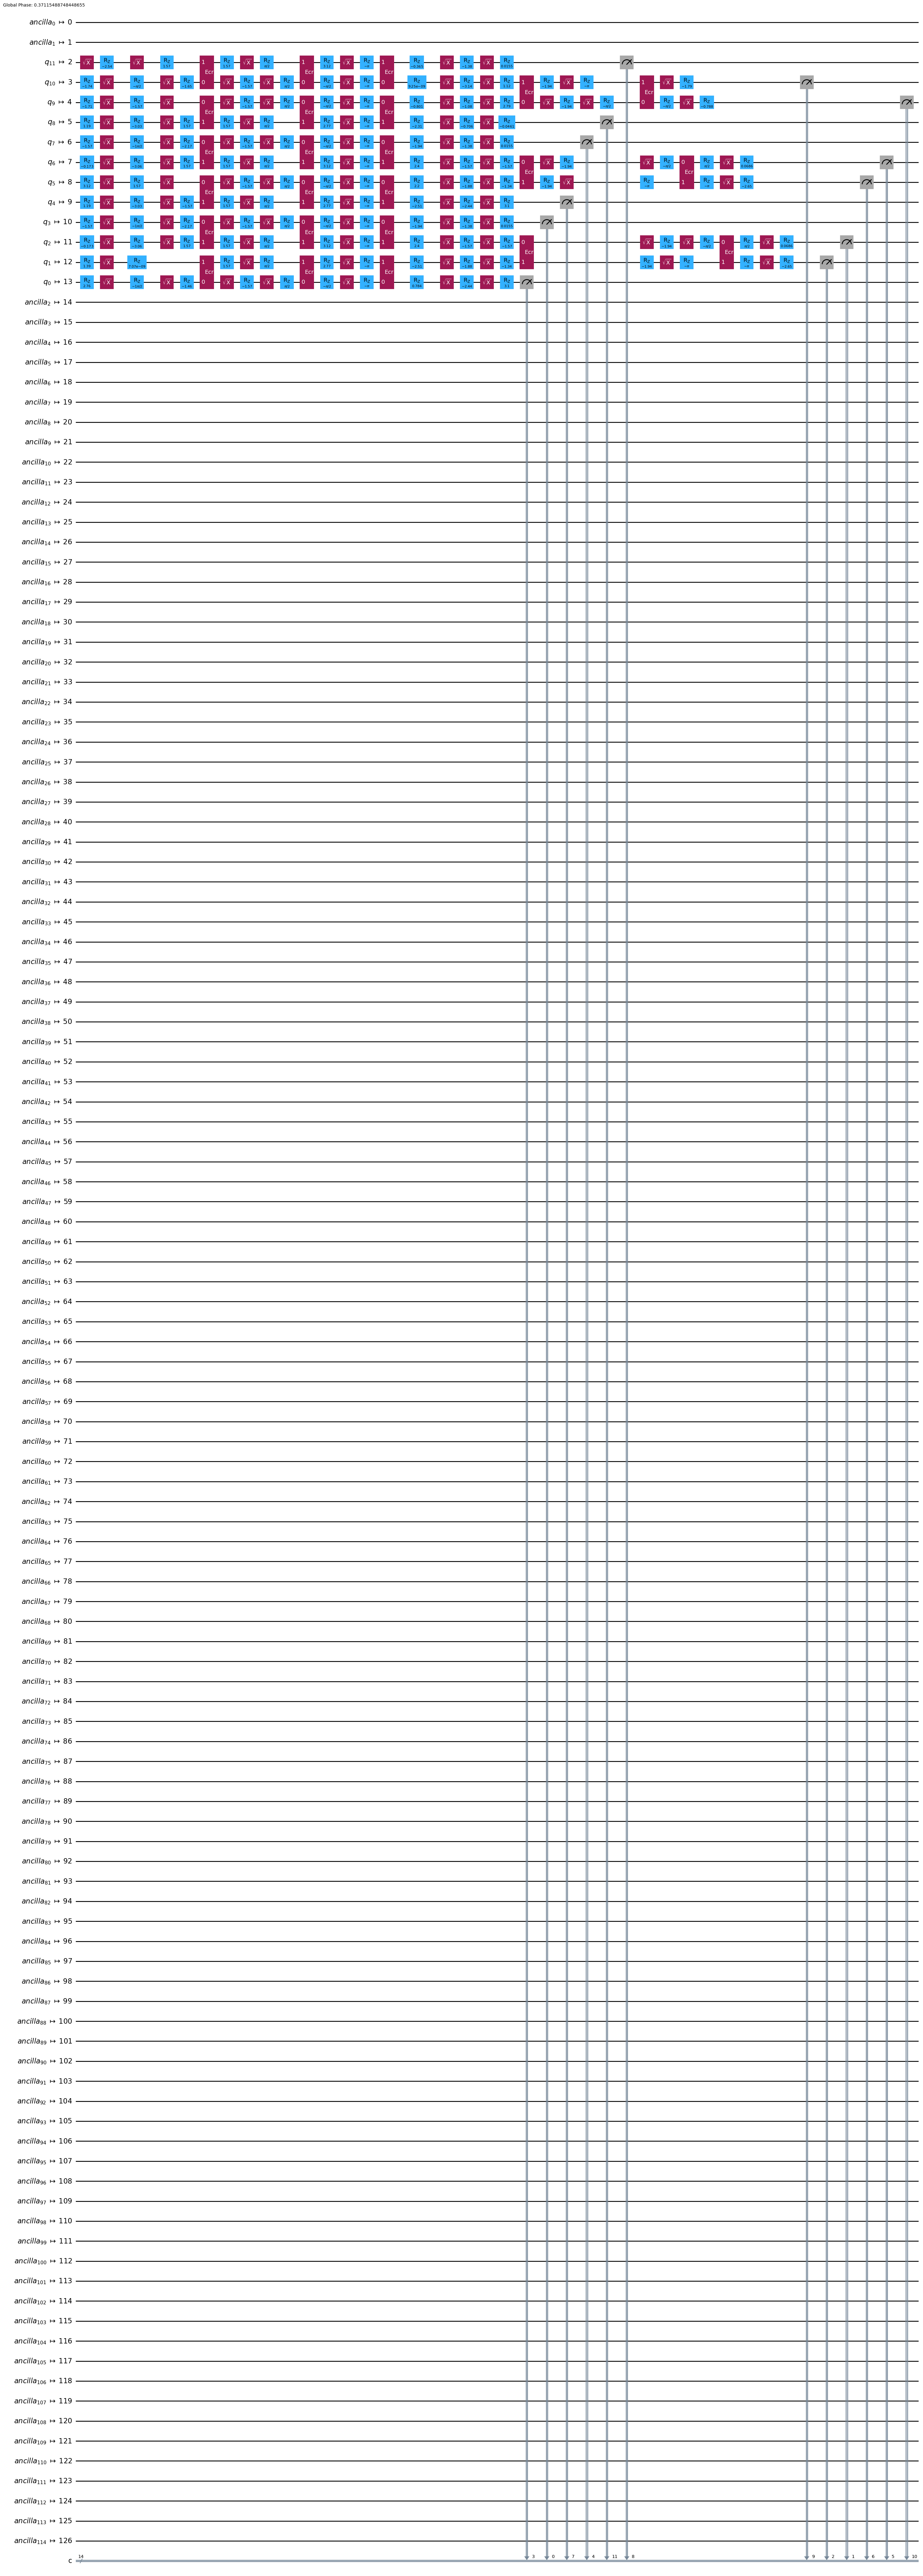

In [146]:
t_qc.draw("mpl",fold = 1000000)

In [147]:
# Full quasidistribution
quasi_dist = sampler_sim_brisbane.run(t_qc, shots = 1000).result().quasi_dists[0].binary_probabilities()
quasi_dist

{'00010101101110': 0.001,
 '00011111100000': 0.001,
 '00001011110001': 0.001,
 '00010110100111': 0.001,
 '00000001010110': 0.001,
 '00000100100001': 0.001,
 '00011100111101': 0.001,
 '00000101000010': 0.001,
 '00111011101111': 0.001,
 '00010011100001': 0.001,
 '00001001010101': 0.001,
 '00000111000010': 0.001,
 '00000111000110': 0.001,
 '00001000100001': 0.001,
 '00001001000001': 0.001,
 '00011101011101': 0.001,
 '00001110100110': 0.001,
 '00010100000110': 0.001,
 '00111101100001': 0.001,
 '00000111010101': 0.001,
 '00001100010000': 0.001,
 '00111001110110': 0.001,
 '00001000110001': 0.001,
 '00001000110111': 0.002,
 '00001010101111': 0.001,
 '00101101101110': 0.001,
 '00010011100101': 0.001,
 '00101001100111': 0.002,
 '00101111100110': 0.001,
 '00111100100100': 0.001,
 '00011111101110': 0.001,
 '00000101100010': 0.001,
 '00000000100110': 0.001,
 '00111100110011': 0.001,
 '00000100110000': 0.001,
 '00010100100100': 0.001,
 '00000111100110': 0.001,
 '00110000100111': 0.001,
 '0001110001

In [148]:
# Split the distribution to subgroups
subgroup_quasi_dists = split_quasi_dist(qubit_subgroups, quasi_dist)
subgroup_quasi_dists

[{'0111': 0.02500000000000001,
  '0000': 0.04000000000000002,
  '1000': 0.08300000000000005,
  '1110': 0.28900000000000015,
  '0110': 0.1670000000000001,
  '1011': 0.017,
  '0100': 0.10200000000000006,
  '1111': 0.04300000000000001,
  '1010': 0.08000000000000004,
  '0010': 0.04200000000000002,
  '1100': 0.05900000000000002,
  '0101': 0.013000000000000001,
  '1101': 0.010000000000000002,
  '0001': 0.009000000000000001,
  '1001': 0.010000000000000002,
  '0011': 0.011000000000000003},
 {'0110': 0.1620000000000001,
  '0111': 0.04100000000000002,
  '1111': 0.04800000000000002,
  '0101': 0.018000000000000006,
  '1010': 0.041000000000000016,
  '0100': 0.11500000000000007,
  '1100': 0.08000000000000003,
  '0010': 0.019000000000000006,
  '0011': 0.012000000000000004,
  '0000': 0.04100000000000002,
  '1011': 0.016000000000000007,
  '1000': 0.07700000000000003,
  '1110': 0.30500000000000016,
  '0001': 0.007,
  '1001': 0.011000000000000003,
  '1101': 0.007},
 {'1010': 0.03900000000000001,
  '1110'

In [149]:
# Correcting the measurement error for each group
backend = backend_sim_brisbane
subgroup_quasi_dists_corrected = [mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend) for (qubit_subgroup, quasi_dist) in  zip(qubit_subgroups, subgroup_quasi_dists)]

In [150]:
# Convert to probabilities vectors
subgroup_prob_dists_corrected = [quasidist_bits_to_array(s, N_qubits) for s in subgroup_quasi_dists_corrected]

In [151]:
# Average all distributions
quasi_dists_av = avarage_distributions(subgroup_quasi_dists_corrected)
prob_dists_av = quasidist_bits_to_array(quasi_dists_av, N_qubits)

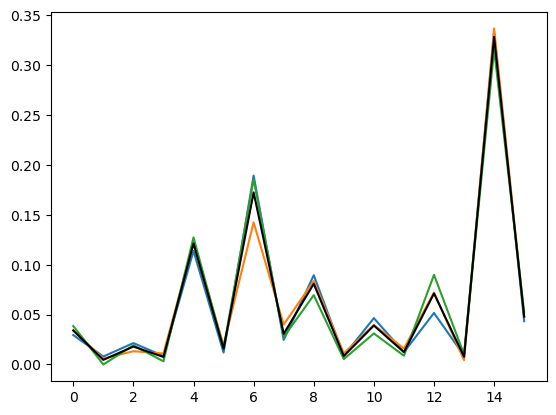

In [152]:
for s in subgroup_prob_dists_corrected:
    plt.plot(s)

plt.plot(prob_dists_av, 'k')

In [153]:
# Convert to mthree object to obtain expect values
quasi_dists_av = mthree.classes.ProbDistribution(quasi_dists_av)

observables = []
for i in range(N_qubits):
    obsev = ['i']*N_qubits
    obsev[i] = 'z'
    observables += [''.join(obsev)]

[quasi_dists_av.expval(observ) for observ in observables]

[-0.19137615065474217,
 -0.5902853567822198,
 -0.3122254219906294,
 0.72985996593089]

# Simulate the 127 qubit chip sequentioully simulating the subgroups on the noisy simulator

In [159]:
1e3*(1e3) * (250 * 1e-6)  / 13

19.23076923076923

In [154]:
# Since we can not siulate 127 qubits at ones we should rin a loop over individula subgroups on the chip

In [113]:
N_circuits = len(snake_qubit_inds) // N_qubits

N_qubits_tot = N_circuits*N_qubits
snake_qubit_inds_active = snake_qubit_inds[:N_qubits_tot]
# Subgroups to encode the circuits
qubit_subgroups = snake_qubit_inds_active.reshape(-1,N_qubits)

In [132]:
N_shots = 1000
subgroup_quasi_dists = []
for qubit_subgroup in qubit_subgroups:

    # Fit into QPU
    t_qc = transpile(
      circuit,
      backend_sim_brisbane,
      initial_layout=qubit_subgroup,
      optimization_level=3,
    )
    t_qc.add_bits(ClassicalRegister(N_qubits))
    t_qc.measure(qubit_subgroup, range(N_qubits))

    subgroup_quasi_dist = sampler_sim_brisbane.run(t_qc, N_shots = 1000).result().quasi_dists[0].binary_probabilities()
    subgroup_quasi_dists += [subgroup_quasi_dist]

/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viach

In [133]:
subgroup_quasi_dists

[{'1011': 0.0107421875,
  '0010': 0.046875,
  '0111': 0.01953125,
  '1001': 0.01171875,
  '0101': 0.0234375,
  '1101': 0.009765625,
  '1111': 0.0380859375,
  '1010': 0.0830078125,
  '0011': 0.0107421875,
  '0001': 0.0087890625,
  '1100': 0.072265625,
  '0100': 0.09765625,
  '0110': 0.1650390625,
  '0000': 0.033203125,
  '1000': 0.083984375,
  '1110': 0.28515625},
 {'1010': 0.0458984375,
  '0100': 0.1044921875,
  '1100': 0.080078125,
  '1001': 0.0078125,
  '1000': 0.0732421875,
  '1110': 0.279296875,
  '0000': 0.0283203125,
  '0010': 0.0263671875,
  '0110': 0.21484375,
  '0101': 0.01953125,
  '0001': 0.005859375,
  '0011': 0.00390625,
  '1101': 0.013671875,
  '1111': 0.0537109375,
  '0111': 0.03125,
  '1011': 0.01171875},
 {'0111': 0.0302734375,
  '0010': 0.021484375,
  '0101': 0.01171875,
  '1011': 0.0078125,
  '0000': 0.0341796875,
  '1101': 0.0126953125,
  '1111': 0.041015625,
  '1010': 0.0322265625,
  '1001': 0.01171875,
  '1110': 0.36328125,
  '0100': 0.107421875,
  '1100': 0.06445

In [134]:
# Correcting the measurement error for each group
backend = backend_sim_brisbane
subgroup_quasi_dists_corrected = [mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend) for (qubit_subgroup, quasi_dist) in  zip(qubit_subgroups, subgroup_quasi_dists)]

In [135]:
# Convert to probabilities vectors
subgroup_prob_dists_corrected = [quasidist_bits_to_array(s, N_qubits) for s in subgroup_quasi_dists_corrected]

In [136]:
# Average all distributions
quasi_dists_av = avarage_distributions(subgroup_quasi_dists_corrected)
prob_dists_av = quasidist_bits_to_array(quasi_dists_av, N_qubits)

In [137]:
quasi_dists_av

{'0000': 0.02496543261156238,
 '0001': 0.0045497641261094835,
 '0010': 0.02351599626326727,
 '0011': 0.006080273372847795,
 '0100': 0.11847124973541602,
 '0101': 0.018810581041973508,
 '0110': 0.18744815236837173,
 '0111': 0.026763247828351013,
 '1000': 0.07477325648051686,
 '1001': 0.009821132297572484,
 '1010': 0.045014829641659274,
 '1011': 0.009083605661090398,
 '1100': 0.06344869411630807,
 '1101': 0.009118515907329355,
 '1110': 0.3309675046312423,
 '1111': 0.047167763916382104}

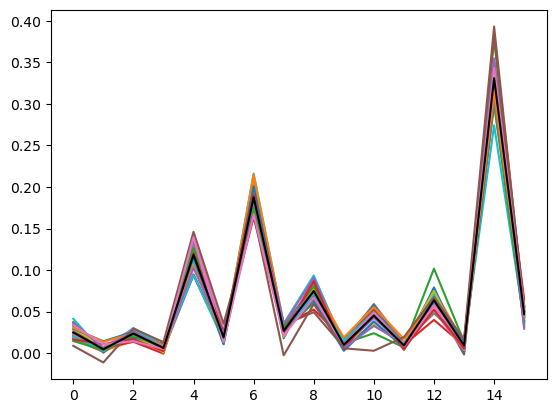

In [138]:
for s in subgroup_prob_dists_corrected:
    plt.plot(s)

plt.plot(prob_dists_av, 'k')

In [139]:
# Convert to mthree object to obtain expect values
quasi_dists_av = mthree.classes.ProbDistribution(quasi_dists_av)

observables = []
for i in range(N_qubits):
    obsev = ['i']*N_qubits
    obsev[i] = 'z'
    observables += [''.join(obsev)]

[quasi_dists_av.expval(observ) for observ in observables]

[-0.17879060530420166,
 -0.6043914190907482,
 -0.35208274736642375,
 0.7372102316966878]